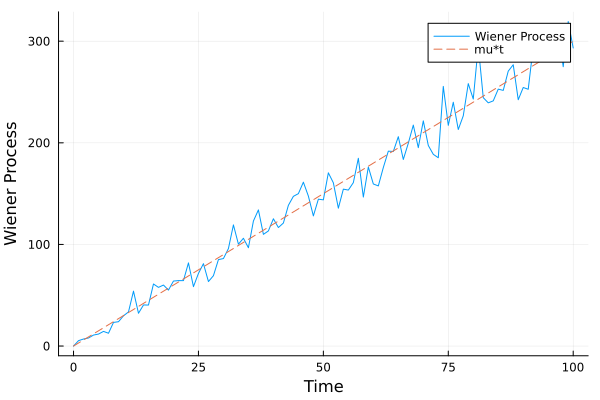

In [1]:
using Plots
import Plots: plot!, vline!



mutable struct WienerProcess{T<:Number}
    mu::T
    sigma2::T
    timestep::T
    values::Vector{T}
    steps::Int
    times::Array{T, 1}

    # Constructeur pour initialiser le processus sans valeurs simulées
    function WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number
        new{T}(mu, sigma2, timestep, Vector{T}(), steps, collect(0:timestep:steps * timestep))
    end
end


function simulate!(process::WienerProcess)
    # Calculer les valeurs accumulées pour simuler le processus de Wiener
    process.values = (randn(process.steps + 1) .* sqrt.(process.sigma2 .* process.times)) .+ process.mu .* process.times
end


# Méthode pour tracer le processus de Wiener
function plot!(process::WienerProcess)
    # Tracer le processus de Wiener
    plot!(process.times, process.values, xlabel="Time", ylabel="Wiener Process", label="Wiener Process", legend=:topright)
    
    # Tracer la droite mu*t
    plot!(process.times, process.mu .* process.times, label="mu*t", linestyle=:dash)
end


# Définir les paramètres du processus de Wiener
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 100

# Créer une instance de WienerProcess
process = WienerProcess{Float64}(mu, sigma2, timestep, steps)

# Simuler le processus de Wiener
simulate!(process)

# Tracer le processus de Wiener simulé
plot!(process)

In [2]:

# Définir la structure mutable pour le modèle ARD1 basé sur le processus de Wiener
mutable struct WienerARD1
    underlying_process::WienerProcess
    rho::Float64
    maintenance_times::Vector{<:Number}
    eps::Float64
    values::Vector{<:Number}
    new_times::Vector{<:Number}

    # Constructeur pour WienerARD1
    function WienerARD1(mu::Float64, sigma2::Float64, timestep::Float64, steps::Int, rho::Float64, maintenance_times::Vector{<:Number}, eps::Float64)
        underlying_process = WienerProcess{Float64}(mu, sigma2, timestep, steps)
        simulate!(underlying_process)
        new(underlying_process, rho, maintenance_times, eps)
    end

end



In [3]:
function adjust_times!(process::WienerARD1)
    new_times = Float64[]
    eps = process.eps
    println(eps)
    for t in process.underlying_process.times
        if t in process.maintenance_times
            push!(new_times, t)
            push!(new_times, t)
        else
            push!(new_times, t)
        end
    end

    process.new_times = new_times
end

adjust_times! (generic function with 1 method)

In [4]:
function adjust_values!(process::WienerARD1)
    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)
    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, process.values[1:last_before_maintenance])
    end

    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        append!(new_values, process.underlying_process.values[between_maintenances[1]-1]- process.rho * process.underlying_process.values[between_maintenances[1]-1])
        println(process.underlying_process.values[between_maintenances[end]+1]- process.rho * process.underlying_process.values[between_maintenances[1]-1])
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, process.values[between_maintenances])
        end
    end
    append!(new_values, process.underlying_process.values[process.maintenance_times[end]+1] - process.rho * process.underlying_process.values[process.maintenance_times[end]+1])
    append!(new_values, process.values[process.maintenance_times[end]+2:end])
    process.values = new_values
end

adjust_values! (generic function with 1 method)

In [5]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 10
rho = 0.5
maintenance_times = [3, 6, 9]
epsilon = 0.1

# Créer une instance de WienerProcess
processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times, epsilon)
adjust_times!(processARD1)
print(processARD1.new_times)

0.1


[0.0, 1.0, 2.0, 3.0, 3.0, 4.0, 5.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0]

In [6]:
function simulate!(process::WienerARD1)
    
    # Créer un vecteur Y initialisé avec les valeurs de X
    Y = copy(process.underlying_process.values)
    
    # Modifier les valeurs de Y selon les règles spécifiées
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i+1]
        
        # Indices des temps entre deux instants de maintenance
        indices = findall(t -> t > maintenance_time && t <= next_maintenance_time, process.underlying_process.times)
        
        # Mettre à jour les valeurs de Y
        Y[indices] .-= process.rho .* process.underlying_process.values[maintenance_time]
    end
    
    indices = findall(t -> t > process.maintenance_times[length(process.maintenance_times)], process.underlying_process.times)
    Y[indices] .-= process.rho .* process.underlying_process.values[process.maintenance_times[length(process.maintenance_times)]]
    # Mettre à jour les valeurs de Y dans la structure process
    process.values = Y
end



simulate! (generic function with 2 methods)

In [7]:
simulate!(processARD1)
println(processARD1.values)

adjust_values!(processARD1)
println(processARD1.values)


[0.0, 2.748616081827927, 6.638020004100642, 13.32776303426693, 14.891351266513889, 12.118707221295445, 15.8521104033702, 18.776004603750966, 5.707205735080168, 12.731273340512576, 24.372595805651063]


19.830981698290383
21.50006777631733
[0.0, 2.748616081827927, 6.638020004100642, 13.32776303426693, 6.663881517133465, 14.891351266513889, 12.118707221295445, 15.8521104033702, 9.58556020271026, 18.776004603750966, 5.707205735080168, 12.731273340512576, 10.22506597609273, 24.372595805651063]


In [8]:

println(processARD1.underlying_process.values)
println(processARD1.underlying_process.times)

[0.0, 2.748616081827927, 6.638020004100642, 13.32776303426693, 18.21036126856421, 15.437717223345766, 19.17112040542052, 26.494863215423848, 13.426064346753051, 20.45013195218546, 31.08562797902759]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


In [9]:
processARD1.underlying_process.values[maintenance_times]

3-element Vector{Float64}:
  6.638020004100642
 15.437717223345766
 13.426064346753051

In [10]:
using Plots
import Plots: plot!, vline!
# Méthode pour tracer le processus de Wiener avec les temps de maintenance
function plot!(process::WienerARD1)
    # Tracer le processus de Wiener
    # plot(process.underlying_process.times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    plot(process.new_times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    # Tracer la droite mu*t
    plot!(process.underlying_process.times, process.underlying_process.mu .* process.underlying_process.times, label="mu*t", linestyle=:dash)

    vline!(process.maintenance_times, label="Maintenance Time", color=:red)
end



plot! (generic function with 6 methods)

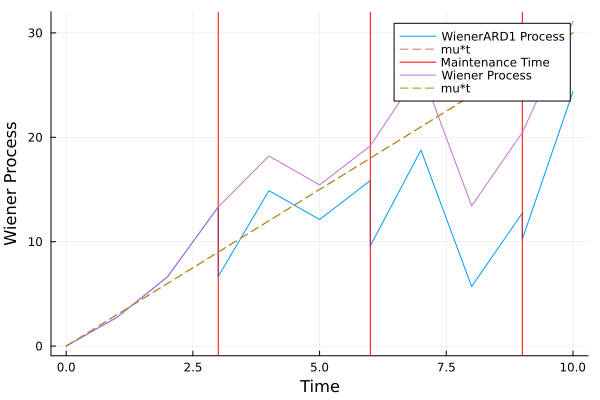

In [11]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
plot!(processARD1.underlying_process)


In [12]:
function select_points!(process::WienerARD1)
    times = process.underlying_process.times
    values = process.values
    selected_times = [times[1]]
    selected_values = [values[1]]
    unselected_times = Float64[]
    unselected_values = Float64[]

    # Trouver l'indice du premier instant de maintenance
    indices = findall(t -> t < maintenance_times[1], times)
    
    # Ajouter des points avant le premier instant de maintenance
    if length(indices) >= 5
        step = div(length(indices), 5)
        selected_indices = [indices[1], indices[end]]
        append!(selected_times, times[selected_indices])
        append!(selected_values, values[selected_indices])
    end

    # Ajouter les points entre les instants de maintenance successifs
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i + 1]
        
        indices = findall(t -> t > maintenance_time && t < next_maintenance_time, times)
        
        if length(indices) >= 5
            step = div(length(indices), 5)
            selected_indices = [indices[1], indices[end]]
            append!(selected_times, times[selected_indices])
            append!(selected_values, values[selected_indices])
        end
    end
    
    # Trouver l'indice du premier instant de maintenance
    indices = findall(t -> t > maintenance_times[end], times)
    
    # Ajouter des points avant le premier instant de maintenance
    if length(indices) >= 5
        step = div(length(indices), 5)
        selected_indices = [indices[1], indices[end]]
        append!(selected_times, times[selected_indices])
        append!(selected_values, values[selected_indices])
    end

    # Trouver les indices dans times mais pas dans selected_times
    indices_unselected_times = findall(t -> !(t in selected_times), times)
    
    # Trouver les indices dans times mais pas dans selected_times
    indices_unselected_values = findall(t -> !(t in selected_values), values)
    

    return selected_times, selected_values, times[indices_unselected_times], values[indices_unselected_values]
end


select_points! (generic function with 1 method)

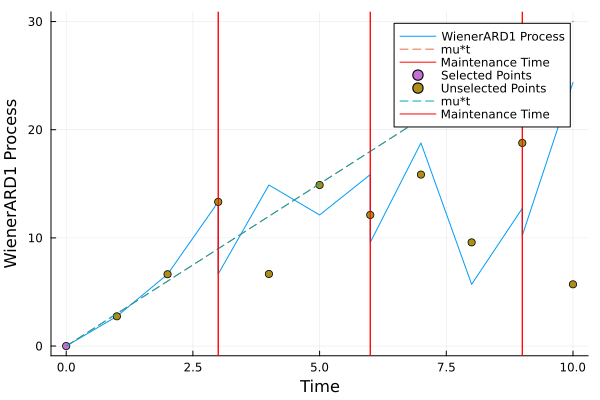

In [13]:
# Exemple d'utilisation de la nouvelle fonction
selected_times, selected_values, unselected_times, unselected_values = select_points!(processARD1)

# Tracer le processus de Wiener avec les points sélectionnés
plot!(processARD1)
plot!(selected_times, selected_values, seriestype=:scatter, xlabel="Time", ylabel="WienerARD1 Process", label="Selected Points", legend=:topright)
plot!(unselected_times, unselected_values, seriestype=:scatter, xlabel="Time", ylabel="WienerARD1 Process", label="Unselected Points", legend=:topright)

plot!(processARD1.underlying_process.times, processARD1.underlying_process.mu .* processARD1.underlying_process.times, label="mu*t", linestyle=:dash)
vline!(processARD1.maintenance_times, label="Maintenance Time", color=:red)
